In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation([-30, 30]),
     transforms.RandomHorizontalFlip(p=0.7),
     transforms.RandomVerticalFlip(p=0.6),
     transforms.RandomGrayscale(p=0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
50000


Let us show some of the training images, for fun.



  cat   car  bird  bird


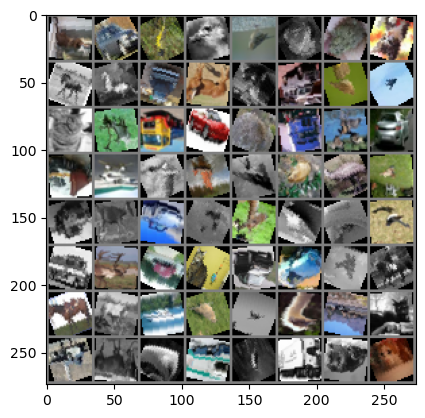

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Using GPU to Training

In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce GTX 1080 Ti


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.dropout = nn.Dropout(p=0.3)
        self.pool = nn.MaxPool2d(2,2)

        #input 3*32*32
        self.conv1 = nn.Conv2d(3, 256, 5)
        #input 256*14*14 
        self.conv2 = nn.Conv2d(256, 512, 3)
        self.conv2_bn = nn.BatchNorm2d(512)
        #input 512*6*6
        self.conv3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(512)
        #input 512*6*6
        self.conv4 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*6*6, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 144)
        self.fc3 = nn.Linear(144, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2_bn(self.conv2(x))))
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)))
        x = self.dropout(x)
        
        x = x.view(-1, 256 * 6 * 6)
        x = F.leaky_relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net().to(device)
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]          19,456
         MaxPool2d-2          [-1, 256, 14, 14]               0
            Conv2d-3          [-1, 512, 12, 12]       1,180,160
       BatchNorm2d-4          [-1, 512, 12, 12]           1,024
         MaxPool2d-5            [-1, 512, 6, 6]               0
            Conv2d-6            [-1, 512, 6, 6]       2,359,808
       BatchNorm2d-7            [-1, 512, 6, 6]           1,024
           Dropout-8            [-1, 512, 6, 6]               0
            Conv2d-9            [-1, 256, 6, 6]       1,179,904
      BatchNorm2d-10            [-1, 256, 6, 6]             512
          Dropout-11            [-1, 256, 6, 6]               0
           Linear-12                  [-1, 256]       2,359,552
      BatchNorm1d-13                  [-1, 256]             512
          Dropout-14                  [

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(net.parameters(), lr=0.45e-3)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.




Epoch:1
	Batch:782 of 782 loss:1.352 loss:2.312 loss:2.154 loss:1.995 loss:1.697loss:1.588
Epoch:2
	Batch:782 of 782 loss:1.693 loss:1.402 loss:1.227 loss:1.287
Epoch:3
	Batch:782 of 782 loss:1.460 loss:1.317 loss:1.174
Epoch:4
	Batch:782 of 782 loss:1.173 loss:1.257loss:1.127
Epoch:5
	Batch:782 of 782 loss:1.097 loss:1.088loss:0.996loss:1.073loss:1.064
Epoch:6
	Batch:782 of 782 loss:1.295 loss:1.144 loss:0.989 loss:1.110
Epoch:7
	Batch:782 of 782 loss:0.860loss:1.305 loss:0.999 loss:0.945
Epoch:8
	Batch:782 of 782 loss:0.523loss:0.880
Epoch:9
	Batch:782 of 782 loss:1.234
Epoch:10
	Batch:782 of 782 loss:0.763 loss:1.150 loss:0.960 loss:0.848loss:0.863
Epoch:11
	Batch:782 of 782 loss:0.816 loss:0.881 loss:1.114 loss:0.834
Epoch:12
	Batch:782 of 782 loss:0.729 loss:1.000 loss:0.895 loss:0.886
Epoch:13
	Batch:782 of 782 loss:1.597 loss:0.907 loss:0.798
Epoch:14
	Batch:782 of 782 loss:1.290 loss:0.703 loss:0.786
Epoch:15
	Batch:782 of 782 loss:1.042loss:0.741 loss:0.882
Epoch:16
	Batch:78

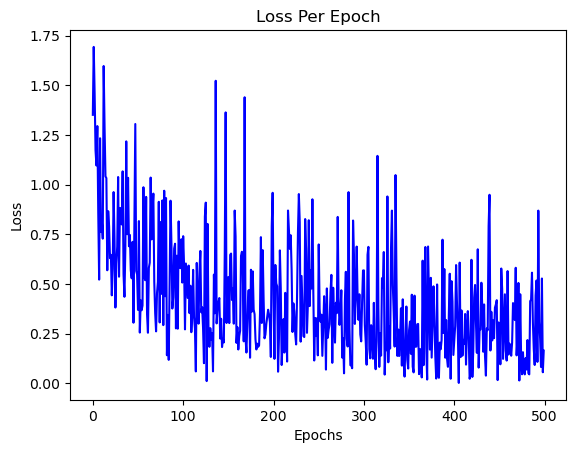

In [8]:
Epochs = 500
LossPerEpoch = np.empty(Epochs)
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i == 0:
          print( f"\nEpoch:{epoch+1}" )
        print( f"\r\tBatch:{i+1:03} of {len(trainloader)}",f"loss:{loss.item():.3f}", end='',flush = True )
        if i + 1 == len(trainloader):
          LossPerEpoch[epoch] = loss.item()
print('\nFinished Training')
plt.plot(LossPerEpoch, 'b')
plt.title('Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


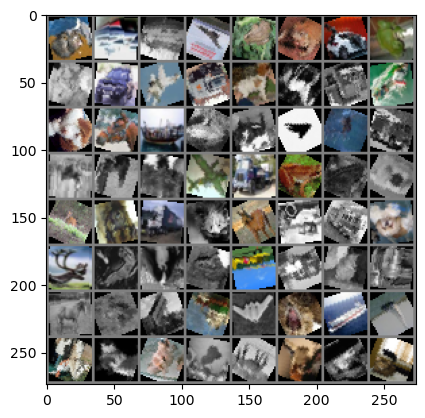

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [10]:
net.eval()
with torch.no_grad():
  outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  deer plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [32]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84.66 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 96 %
Accuracy of  bird : 70 %
Accuracy of   cat : 75 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 89 %
Accuracy of horse : 85 %
Accuracy of  ship : 93 %
Accuracy of truck : 85 %


Display the confusion matrix as a heatmap

Text(83.22222222222221, 0.5, 'label (ground truth)')

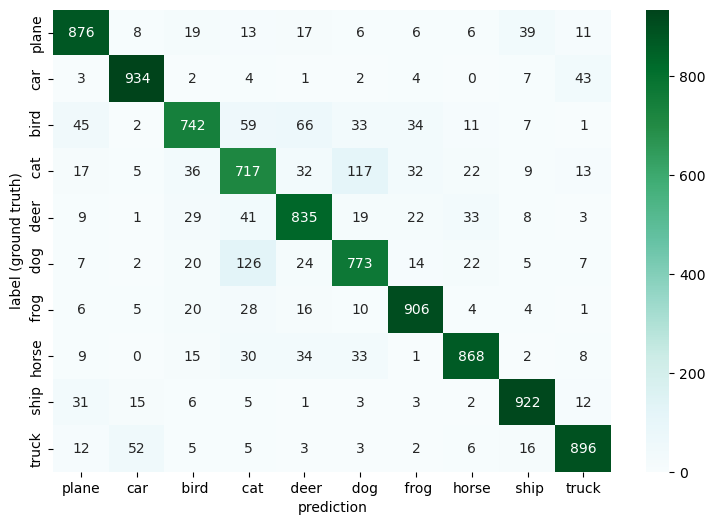

In [14]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

Some multi-class performance report defined from Scikit-learn

In [15]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.86      0.88      0.87      1001
         car       0.91      0.93      0.92      1000
        bird       0.83      0.74      0.78      1000
         cat       0.70      0.72      0.71      1000
        deer       0.81      0.83      0.82      1000
         dog       0.77      0.77      0.77      1000
        frog       0.88      0.91      0.90      1000
       horse       0.89      0.87      0.88      1000
        ship       0.90      0.92      0.91      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.85     10001
   macro avg       0.85      0.85      0.85     10001
weighted avg       0.85      0.85      0.85     10001

